# Artificial Neural Networks and Deep Learning - Homework 1

<h3>Useful links</h3>

- [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- [keras_tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
- [bayesian-optimization-in-cnn](https://www.kaggle.com/code/toniesteves/bayesian-optimization-in-cnn)
- [hyperparameter-search-with-bayesian-optimization-for-keras-cnn-classification-and-ensembling](https://machinelearningapplied.com/hyperparameter-search-with-bayesian-optimization-for-keras-cnn-classification-and-ensembling)
-[NN-SVG](https://alexlenail.me/NN-SVG)
- [tuning_playbook#contributing](https://github.com/google-research/tuning_playbook#contributing)


| Overfitters del test set    | PoliMi ID |
|:----------------------------|:---------:|
|Pertino Paolo                | 10729600  |
|Sandri Alberto               | 10698469  |
|Simionato Enrico             | 10698193  |

In the first homework of the Artificial Neural Networks and Deep Learning course, a binary image classification task is proposed. The goal is to understand from images of plants whether they are healthy or not.

## Table of contents

- [0. Preliminary operations](#0-preliminary-operations)
    - [0.1 Connect to drive](#01-connect-to-drive)
    - [0.2 Download and import libraries](#02-download-and-import-libraries)
- [1. Dataset inspection](#1-dataset-inspection)
    - [1.1 Loading the data](#11-loading-the-data)
    - [1.2 Outliers removal](#12-outliers-removal)

## 0. Preliminary operations

In the following section some preliminary operations in order to setup the environment correctly are performed.

### 0.1 Connect to Drive

In [1]:
try:
    from google.colab import drive
    print("Code running on Google Colab... Conncecting to Google Drive...")
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 1
except:
    print("The code is not running on Google Colab...")

Code running on Google Colab... Conncecting to Google Drive...
Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Homework 1


### 0.2 Download and import Libraries

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install keras
!pip install tqdm
!pip install scikit-learn
!pip install tensorflow[and-cuda]
!pip install shap
!pip install pandas
!pip install scipy
!pip install Cython
!pip install opencv-python

In [91]:
# Fix randomness and hide warnings
seed = 42

import os
import warnings
import logging
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

random.seed(seed)

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
#import shap
import cv2
np.random.seed(seed)

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.mobilenet import preprocess_input
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

2.14.0
Num GPUs Available: 1


## 1. Dataset inspection

In this section the content of the dataset is inspected and the images are prepared for later analysis.

### 1.1 Loading the data

In [7]:
data = np.load('data/public_data.npz', allow_pickle=True)

images = data.get('data')
labels = data.get('labels')

images.shape, labels.shape

((5200, 96, 96, 3), (5200,))

As we can see, the dataset is composed by `5200` colored images of size `96x96`.

In [8]:
images_normalized = (images / 255).astype(np.float32)

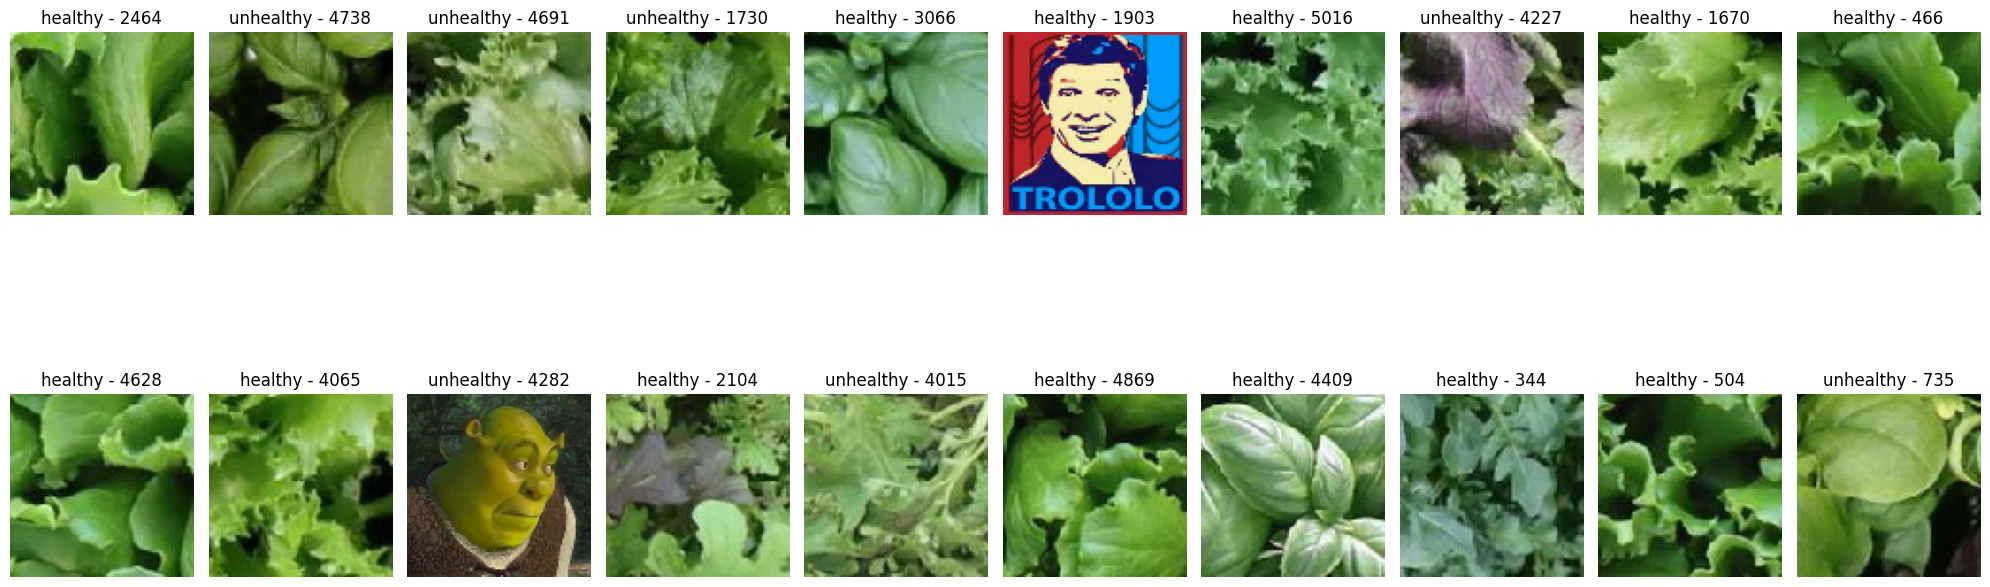

In [9]:
# Number of images to display
num_img = 20

# Create subplots for displaying items
np.random.seed(312)
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i % 2, i % num_img // 2]
    index_shown = np.random.randint(0, len(images))
    ax.imshow(np.clip(images_normalized[index_shown], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f"{labels[index_shown]} - {index_shown}")
plt.tight_layout()
plt.show()

Hey! There are some outliers here! Images with index `4282` and `1903` are not plants :(

### 1.2 Outliers removal

Let's remove the outliers we have just found and all their copies in the dataset (if any).

In [11]:
trololo = images[1903]
shrek = images[4282]

trolls = []
for i in tqdm(range(len(images))):
  if np.array_equiv(images[i], trololo) or np.array_equiv(images[i], shrek):
    trolls.append(i)

print(f"In the dataset there are {len(trolls)} outliers.")

100%|██████████| 5200/5200 [00:00<00:00, 23866.14it/s]

In the dataset there are 196 outliers.


In [12]:
# Deleting the trolls
images_no_outliers = np.delete(images, trolls, axis = 0)
labels_no_outliers = np.delete(labels, trolls, axis = 0)

images_no_outliers.shape, labels_no_outliers.shape

((5004, 96, 96, 3), (5004,))

### 1.3 Storing and loading the dataset without outliers

In [26]:
# Storing the dataset without outliers
np.save('data/public_data_no_outliers', images_no_outliers, allow_pickle=True)
np.save('data/public_labels_no_outliers', labels_no_outliers, allow_pickle=True)

In [28]:
images_no_outliers = np.load('data/public_data_no_outliers.npy', allow_pickle=True)
labels_no_outliers = np.load('data/public_labels_no_outliers.npy', allow_pickle=True)

images_no_outliers.shape, labels_no_outliers.shape

((5004, 96, 96, 3), (5004,))

### 1.4 Plots and statistics

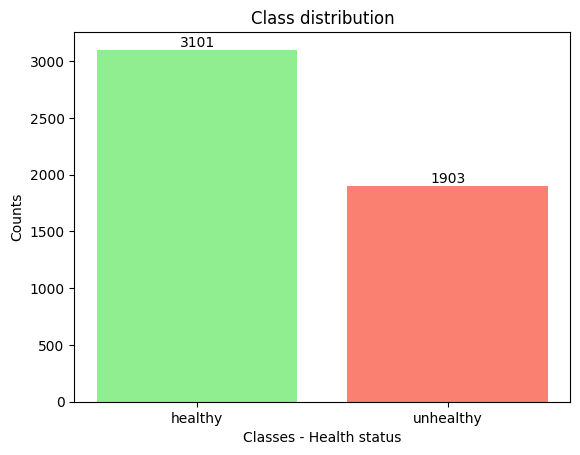

In [45]:
# Create a numpy array of data for the barplot
labels = ['healthy', 'unhealthy']

# Defining the counts
counts = [sum(labels_no_outliers=='healthy'), sum(labels_no_outliers=='unhealthy')]

# Define colors for the bars
colors = ['lightgreen', 'salmon']

# Create the barplot
plt.bar(labels, counts, color=colors)

# Aggiungi etichette agli assi
plt.xlabel('Classes - Health status')
plt.ylabel('Counts')

# Aggiungi un titolo al grafico
plt.title('Class distribution')

# Add numbers on top of the bars
for i, value in enumerate(counts):
  plt.text(labels[i], value, str(value), ha='center', va='bottom')

# Mostra il grafico
plt.show()

The dataset is a little bit unbalanced towards the healthy class since there are 3101 samples in this class against 1903 of the other.

### 1.5 Pre-processing

In [50]:
# Convert labels to one-hot encoding format
y = np.zeros((labels_no_outliers.shape[0], 2))
y[labels_no_outliers=='healthy', 0] = 1.
y[labels_no_outliers=='unhealthy', 1] = 1.

# Setting the input dataset to split
X = (images_no_outliers / 255).astype(np.float32)

# Defining the number of samples in the test set and in the validation set
validation_size = 500
test_size = 500

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=validation_size, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4004, 96, 96, 3), y_train shape: (4004, 2)
X_val shape: (500, 96, 96, 3), y_val shape: (500, 2)
X_test shape: (500, 96, 96, 3), y_test shape: (500, 2)


## 2. Models

### 2.1 Needed function Cross-validation (DA AGGIUSTARE E SISTEMARE TODO (CONCLUSIONS TODO))

In [92]:
def plot_confusion_matrix(model_name, preprocessed_input, y_test):
  '''
  TODO
  '''

  # Loading the model
  model = tf.keras.models.load_model(model_name)

  # Predict labels for the entire test set
  predictions = model.predict(preprocessed_input, verbose=0)

  # Display the shape of the predictions
  print("Predictions Shape:", predictions.shape)

  # Compute the confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
  precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
  recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
  f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

  # Display the computed metrics
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

In [ ]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train_val, y_train_val)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  # Build a new dropout model for each fold
  k_model = build_dropout_model(input_shape, dropout_rate)

  # Train the model on the training data for this fold
  history = k_model.fit(
    x = X_train_val.iloc[train_idx],
    y = y_train_val.iloc[train_idx],
    validation_data=(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx]),
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks,
    verbose = 0
  ).history

  # Evaluate the model on the validation data for this fold
  score = k_model.evaluate(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx], verbose=0)
  scores.append(score[1])

  # Calculate the best epoch for early stopping
  best_epoch = len(history['loss']) - patience
  best_epochs.append(best_epoch)

  # Store the training history for this fold
  histories.append(history)

### 2.2 Custom Baseline

In [81]:
def build_custom_baseline(input_shape, output_shape, seed=seed):
  tf.random.set_seed(seed) # Execution on GPUs loses the deterministic execution guaranteed by the seed

  # Build the neural network layer by layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  # Convolutional layers are linear layers
  conv1 = tfkl.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='swish', name='conv1')(input_layer)

  #conv1_1 = tfkl.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='swish', name='conv1_1')(conv1)

  pool1 = tfkl.MaxPooling2D(pool_size=(2,2), name='mp1')(conv1)

  conv2 = tfkl.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='swish', name='conv2')(pool1)

  #conv2_1 = tfkl.Conv2D(filters=32,kernel_size=(3,3), padding='same',activation='swish', name='conv2_1')(conv2)

  pool2 = tfkl.MaxPooling2D(pool_size =(2,2), name='mp2')(conv2)

  conv3 = tfkl.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='swish', name='conv3')(pool2)

  #conv3_1 = tfkl.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='swish', name='conv3_1')(conv3)

  #pool3 = tfkl.MaxPooling2D(pool_size=(2,2), name='mp3')(conv3)

  #conv4 = tfkl.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='swish', name='conv4')(pool3)

  #conv4_1 = tfkl.Conv2D(filters=128, kernel_size=(3,3),padding='same',activation='swish', name='conv4_1')(conv4)

  gap = tfkl.GlobalAveragePooling2D(name='gap')(conv3)

  classifier_layer1 = tfkl.Dense(
      units=120,
      activation='swish',
      name='dense1'
  )(gap)

  classifier_layer2 = tfkl.Dense(
      units=84,
      activation='swish',
      name='dense2'
  )(classifier_layer1)

  output_layer = tfkl.Dense(
      units=output_shape,
      activation='softmax',
      name='Output'
  )(classifier_layer2)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='custom_baseline')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

  # Return the model
  return model

In [82]:
input_shape = (96, 96, 3)
output_shape = 2

# Build the LeNet model and display its summary
model = build_custom_baseline(input_shape, output_shape)
model.summary()

Model: "custom_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 24, 24, 128)       73856     
                                                                 
 gap (GlobalAveragePooling2  (None, 128)           

In [77]:
#dropout = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

In [ ]:
# Define the hyperparameters
batch_size = 16
epochs = 200

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.999,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5            # Minimum learning rate
)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history

# Save the trained model
model.save('models/custom_baseline_multiple_conv')

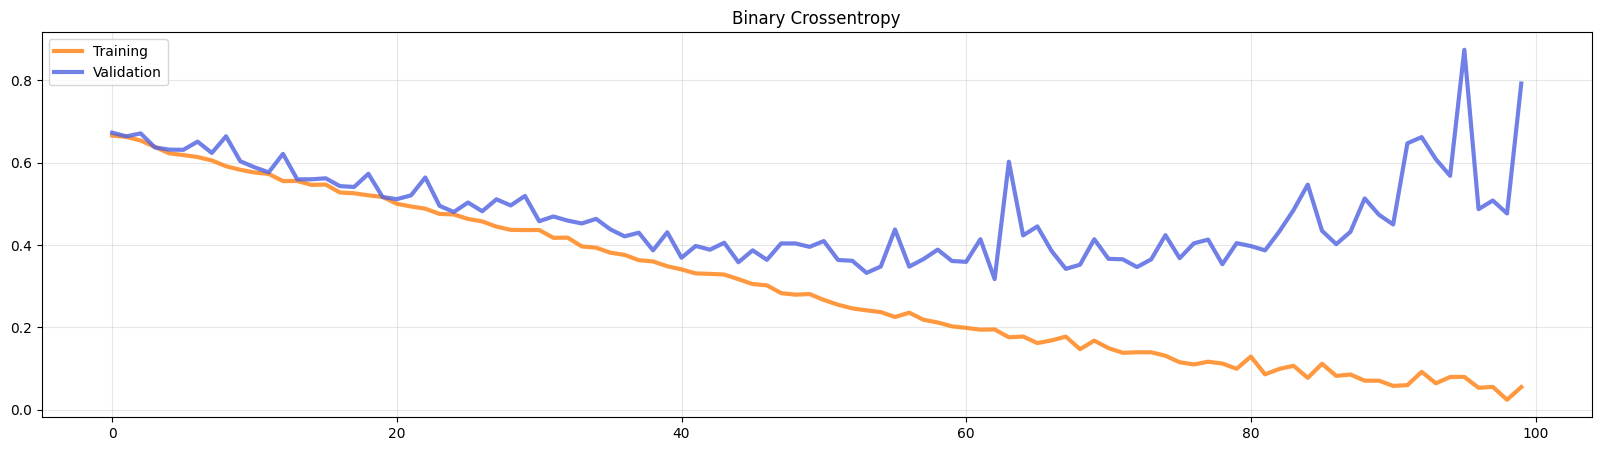

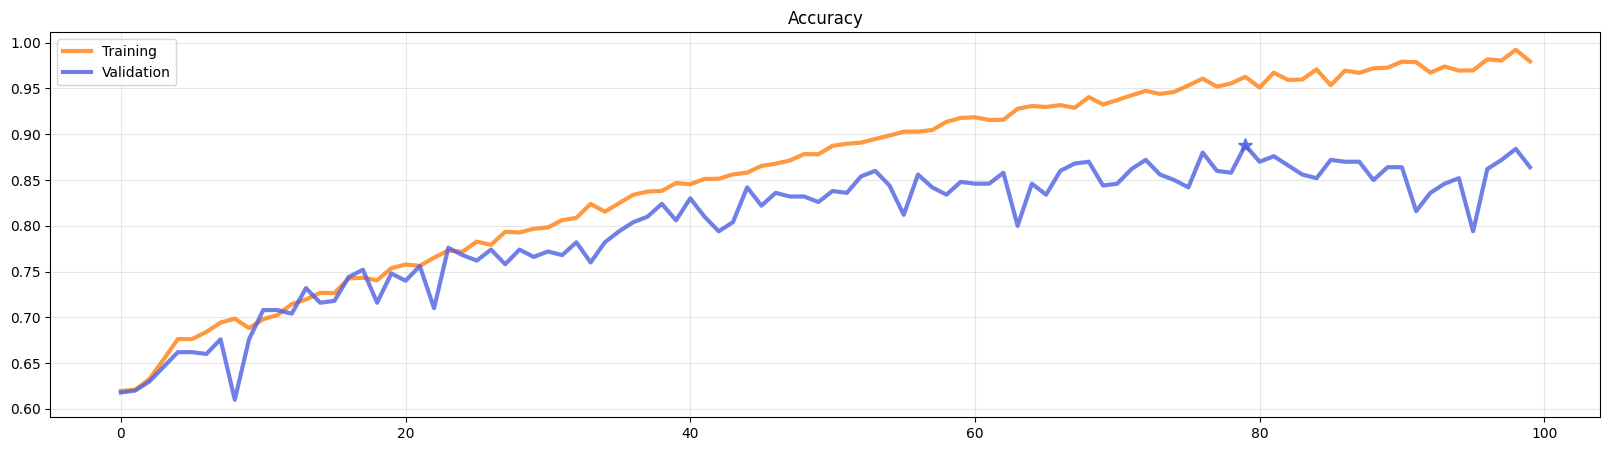

In [84]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

Predictions Shape: (500, 2)
Accuracy: 0.884
Precision: 0.8626
Recall: 0.8263
F1: 0.8441


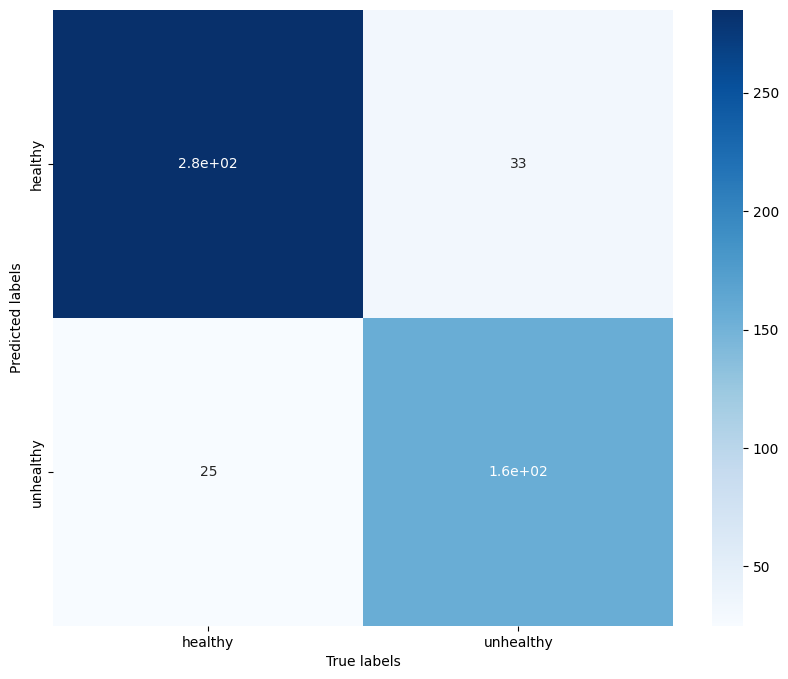

In [93]:
plot_confusion_matrix('models/custom_baseline_multiple_conv', X_test, y_test)

#### Training again on the whole dataset

In [95]:
# Define the test size
test_size = 100

# Split data into train_val and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=np.argmax(y,axis=1))

In [96]:
input_shape = (96, 96, 3)
output_shape = 2

# Build the LeNet model and display its summary
model = build_custom_baseline(input_shape, output_shape)
model.summary()

Model: "custom_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 24, 24, 128)       73856     
                                                                 
 gap (GlobalAveragePooling2  (None, 128)           

In [97]:
# Define the hyperparameters
batch_size = 16
epochs = 200

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='accuracy', patience=20, mode='max', restore_best_weights=True)

# Define learning rate scheduler callback
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='accuracy', patience=lr_patience, factor=0.999, mode='max', min_lr=1e-5)

# Train the model and save its history
history = model.fit(
    x=X,
    y=y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]
).history

# Save the trained model
model.save('models/custom_baseline_multiple_conv_whole_dataset')

Epoch 1/200
313/313 [==============================] - 5s 11ms/step - loss: 0.6652 - accuracy: 0.6151 - lr: 0.0010
Epoch 2/200
313/313 [==============================] - 5s 16ms/step - loss: 0.6573 - accuracy: 0.6243 - lr: 0.0010
Epoch 3/200
313/313 [==============================] - 5s 15ms/step - loss: 0.6529 - accuracy: 0.6363 - lr: 0.0010
Epoch 4/200
313/313 [==============================] - 5s 15ms/step - loss: 0.6392 - accuracy: 0.6599 - lr: 0.0010
Epoch 5/200
313/313 [==============================] - 5s 15ms/step - loss: 0.6262 - accuracy: 0.6685 - lr: 0.0010
Epoch 6/200
313/313 [==============================] - 4s 13ms/step - loss: 0.6152 - accuracy: 0.6793 - lr: 0.0010
Epoch 7/200
313/313 [==============================] - 3s 11ms/step - loss: 0.6086 - accuracy: 0.6865 - lr: 0.0010
Epoch 8/200
313/313 [==============================] - 3s 11ms/step - loss: 0.5927 - accuracy: 0.6906 - lr: 0.0010
Epoch 9/200
313/313 [==============================] - 4s 13ms/step - loss: 0.58

KeyboardInterrupt: ignored

In [98]:
# Save the trained model
model.save('models/custom_baseline_multiple_conv_whole_dataset')

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(best_epoch, history['accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

Predictions Shape: (100, 2)
Accuracy: 0.95
Precision: 1.0
Recall: 0.8684
F1: 0.9296


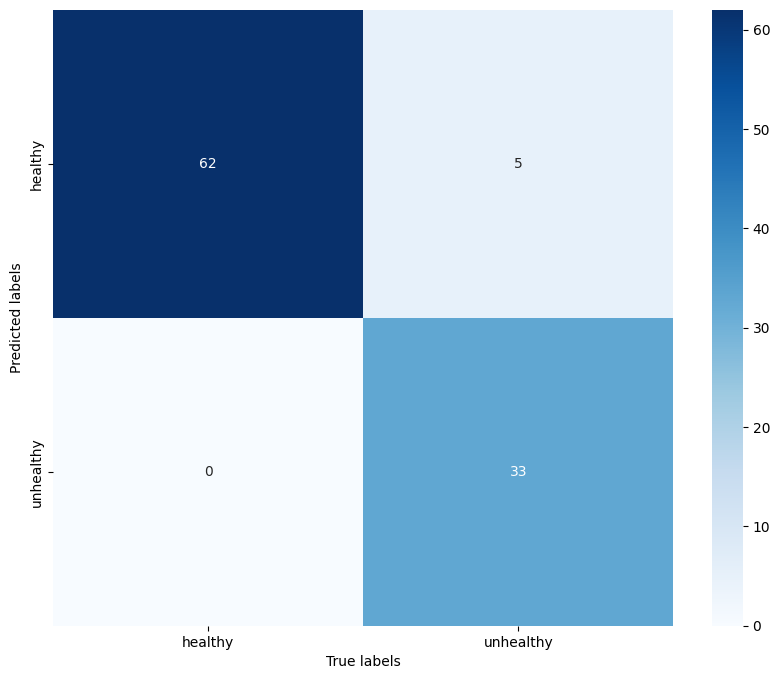

In [99]:
plot_confusion_matrix('models/custom_baseline_multiple_conv_whole_dataset', X_test, y_test)

### 2.2 Paolo's models

### 2.3 Alberto's models (forza Milan)

### 2.4 Enrico's models

## 3. Results and conclusions



In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

# There is no overfitting -> good!

In [ ]:
pred = model.predict(np.expand_dims(images[0], axis=0), verbose=0)
pred, labels[0]

(array([[0.67947716, 0.32052287]], dtype=float32), 'healthy')

### Train MobileNetV2 from scratch

In [ ]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,  # We avoid to include the fully connected layers that
                        # are designed for a 1000-classes classification.
    weights=None,       # We will not download the trained weights, we'll have
                        # only the network (we train from skratch).
    pooling='avg',      # Type of pooling.
)

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

# DepthwiseConv2D is another different type of layer.

# There are skip connections. The most important information are at the lowest
# levels, in sequential networks I can extract information from the last layer,
# adding skip connections, I'm able to exploit information form the both the
# initial and final levels.

# Using skip connections, I need to merge the information coming from different
# layers in the correct way: in case of concatenation, I have to concatenate
# kernels, in case of addition, I have need to have exactly the same shape of
# the activations.

In [ ]:
# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2226434 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Here we are training from skretch the network (this is not transfer learning).
# We are overfitting a lot, the network is completely unable to generalise.
# We can see that the accuracy on the training set is almost 100% and the
# accuracy on the validation set is 50% (random guess).
# The network is not able to generalise since training such a big network is not
# easy and needs some steps to do and some particular techniques. Moreover here
# we have a too small input dataset.

# To train big networks we need to apply particular pipelines of learning rates,
# we need to apply warmup (training using small learning rates).

In [ ]:
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Transfer Learning
Leveraging pre-trained network for a different classification problem

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

# Transfer learning: we want to freeze the parameters of the feature extraction
# network and we want to train the classification head (fully connected NN).

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

In [ ]:
# Evaluate the model on the test set
test_accuracy = tl_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8300


In [ ]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
#plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
#plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
#plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
#plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# We achieved the performance of the network we designed in a small number of
# epochs.

Predictions Shape: (100, 2)
Accuracy: 0.83
Precision: 0.827
Recall: 0.8069
F1: 0.8144


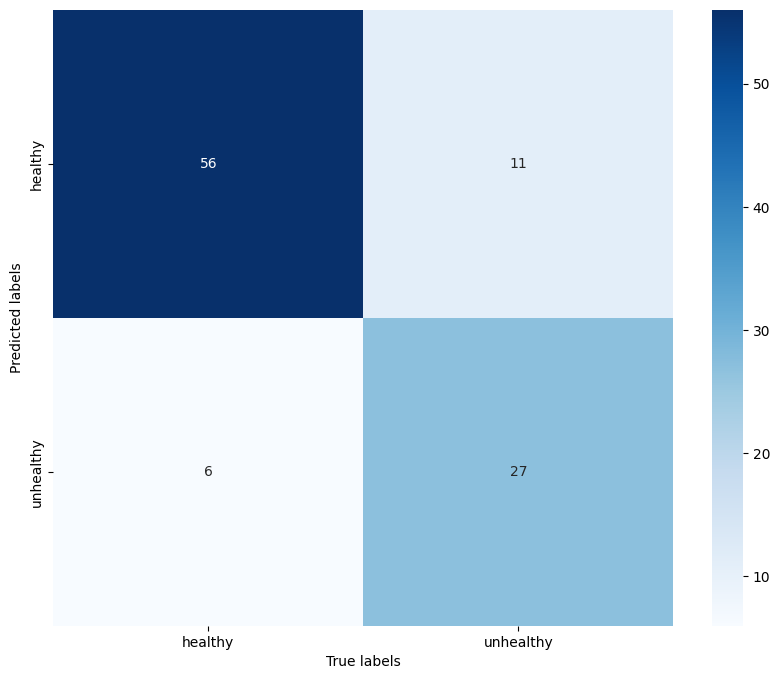

In [ ]:
# Predict labels for the entire test set
predictions = tl_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Still good performances

In [ ]:
# Save the best model
tl_model.save('TransferLearningModel_2')
#del tl_model

In [ ]:
m = tf.keras.models.load_model('trial')

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model( 'trial')

    def predict(self, X):

        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        out = self.model.predict(preprocess_input(X*255))
        out = tf.argmax(out, axis=-1)  # Shape [BS]

        return out

In [ ]:
model = model(os.getcwd())
pred = model.predict(X_test)
pred

2/2 [==============================] - 1s 29ms/step


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])>

In [ ]:
np.argmax(predictions, axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])

## Fine Tuning
Training also the backbone network. To this purpose it is better to
1.   Perform transfer learning, namely train the new classification head only;
2.   Unfreeze the backbone layers (or possibly a few of them depending on the amount of training data) and train the entire netrwork. Note that the classification head needs to be a properly trained model. We adjust the last set of transformations, we use a very small learning rate.

Training a neural network cannot be done end-to-end. Most effective trainings are split in many steps.



In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel_1')
ft_model.summary()

In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

# I can also iteratively unfreeze only some parts of the network and do the
# training, e.g. the first time, only the last layer; the second time, only the
# last two, and so on.
# We can also unfreeze different parts of the networks in different steps of the
# training keeping freezed the others, training alternatively different parts of
# the network. We can change the learning rates training different parts (e.g.
# higher learning rates on the last layers and smaller learning rates in the
# case of the training of the CNN layers).

In [ ]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_3 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# The first epoch is already more performing than all the previous model we have
# created.

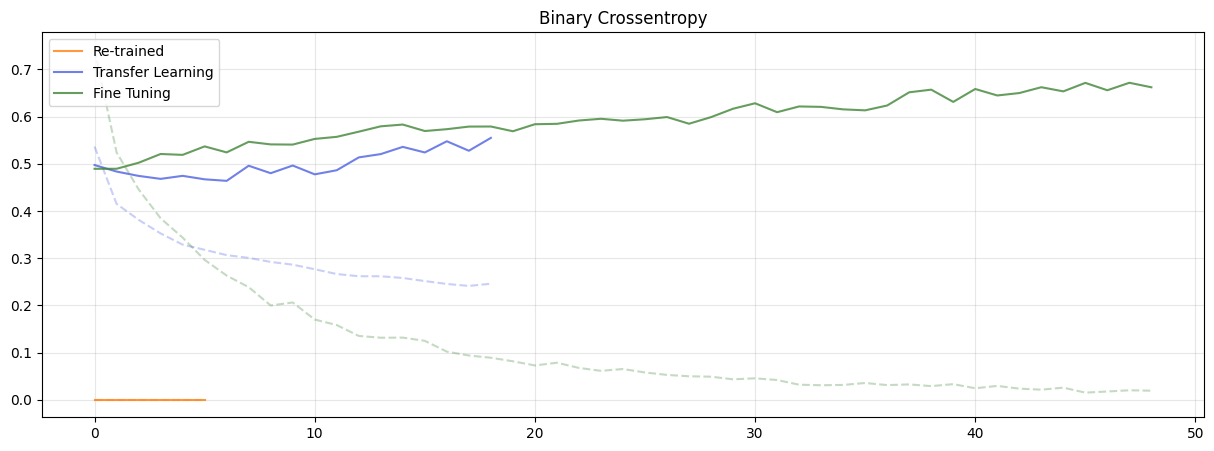

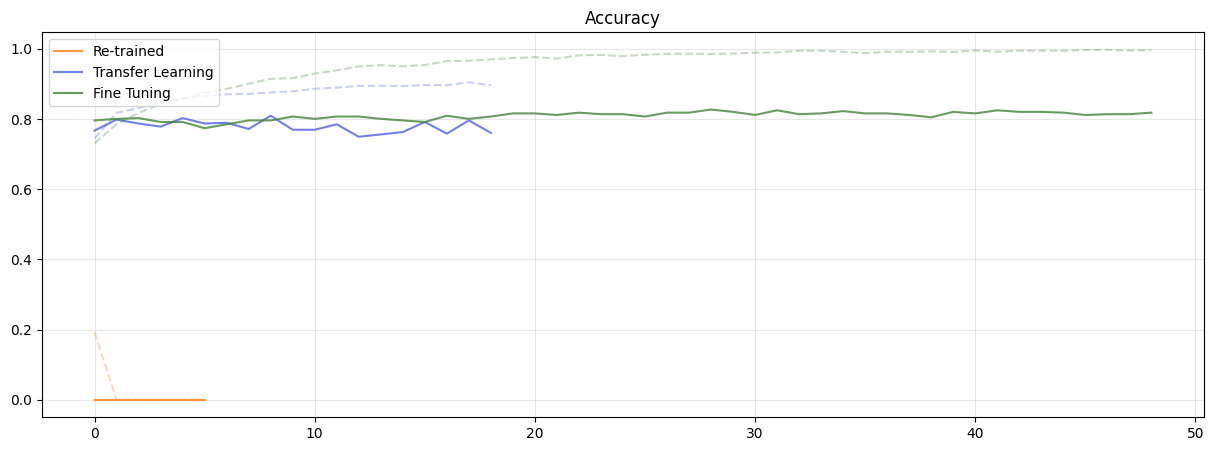

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# We can also skip the transfer learning step but it will be more difficult for
# the network to learn.

In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

# Very good performance on the test set.

[0.7159918546676636, 0.7884231805801392]

[[1.0211155e-04 9.9989784e-01]
 [9.9999988e-01 8.9594650e-08]
 [9.4073421e-01 5.9265766e-02]
 ...
 [8.8477479e-03 9.9115223e-01]
 [9.9960095e-01 3.9906698e-04]
 [5.7495506e-03 9.9425042e-01]]
[1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1
 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1
 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1
 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0
 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1

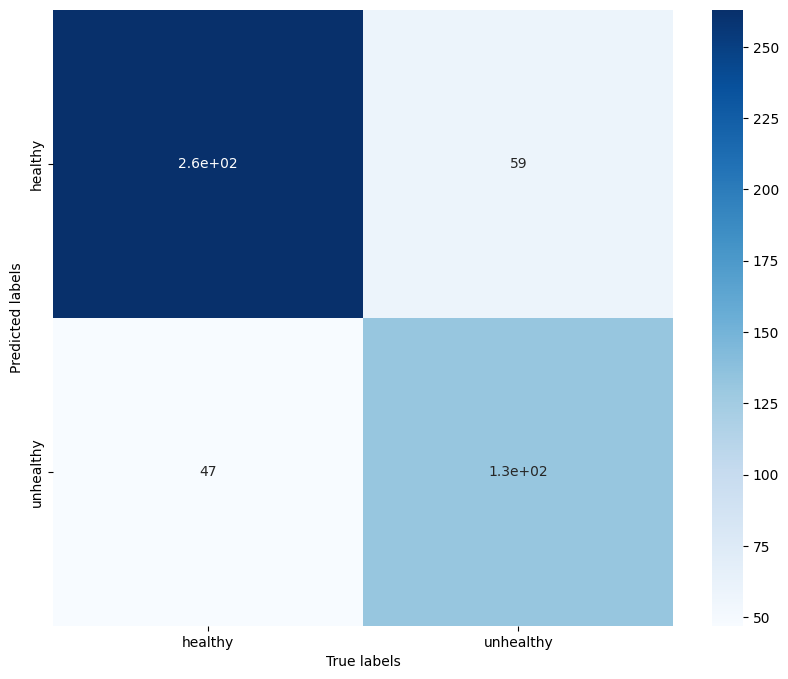

In [ ]:
# Predict labels for the entire test set
predictions = ft_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Still good performances

In [ ]:
# Save the best model
ft_model.save('FineTuningModel')
del ft_model

### Test on your own data

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('FineTuningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 1208642 (4.61 MB)
Non-trainable params: 1051904 (4.01 MB)
_________________________________________________________________


In [ ]:
test_path = 'test_images/'
test = load_images_from_folder(test_path)
test.shape

(4, 224, 224, 3)

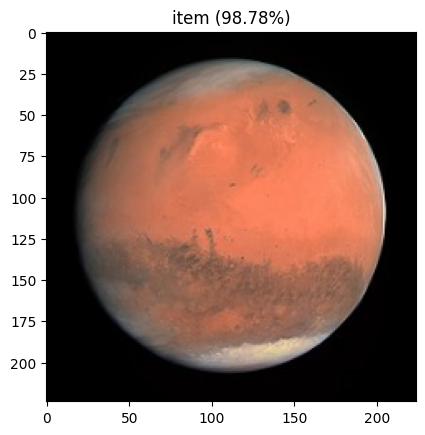

In [ ]:
# predict the test image
test_predictions = ft_model.predict(preprocess_input(test*255), verbose=0)

index = 2
prediction = test_predictions[index]

if prediction[0] >= prediction[1]:
    label = 'item'
    probability = float("{:.{}f}".format(prediction[0], 4))*100

else:
    label = 'animal'
    probability = float("{:.{}f}".format(prediction[1], 4))*100

plt.title(f'{label} ({probability}%)')
plt.imshow(np.squeeze(test[index]))
plt.show()

### TODO Exercise
Practice the various transformations, create your own successful preprocessing pipeline and compare different Keras applications' architectures.

What happens if you combine augmentation techniques with fine tuning?

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*